# Overview

The three main objectives with this project are:
1.	Rank actors on IMDB by importance
2.	Visually present the top ranked actors and their ranking
3.	Explore the data and attempt to find a formula to create a successful movie

## Part 1. Ranking actors on IMDB by importance
First of all, I downloaded the data files from  https://www.imdb.com/interfaces/

The files used for the first and second parts are:

- title.basics.tsv – To get title categorical data for the titles, to filter only movies.
- title.principals.tsv – To get cast categorical data, to filter only actors/actresses.
- title.ratings.tsv – To get ratings of the movies
- name.basics.tsv  – To get names of the actors

I used Pandas to import and explore/filter these files.
My main dataframe was the one created from  title.principals.tsv. I filtered it to only contain actors from movies. I then added ratings and names for each actor. I filtered out all titles where rating was  below 5.0 to reduce runtime. These will likely barely affect the final ranking as I heavily weigh movie ranking in my algorithm. I also filtered out titles with less than 10000 votes, both for statistical significance of the ratings and to reduce runtime, as well the reason that a “successful movie” should probably have more than 10000 votes, as votes are a decent indication of how many have seen the movie. I also filtered out the rows with actors who had appeared in less than 10 of these movies to reduce runtime. This will again likely not affect the end result much as they would end up with a low pagerank score.

I output this filtered dataframe to a new .tsv file, so that it can be easily explored externally and to reduce runtime with multiple runs. I then created a new function to create a network using the data. A NetworkX network was created where the nodes were actors and edge had a weight score. The weight score for each movie is the movie’s ranking to the power of 3 (to increase the weight of ranking in the algorithm). For each movie two actors had been together, the edge’s weight was increased with the new movie’s weight score.

Now we have a network with nodes and appropriately weighted edges. To rank the actors I used the PageRank algorithm. The pagerank() function from the NetworkX package was used with a damping factor of 0.85. I then sorted the result by highest score, and now I got the top ranked actors by importance, according to the PageRank algorithm.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

def filter_data():
    # Read title data (tconst = unique movie id, titleType = type such as movie, tv-show etc.)
    titles_data = pd.read_csv('title.basics.tsv', sep='\t', error_bad_lines=False)
    
    # Filter only movies
    movies = titles_data[(titles_data['titleType'] == 'movie')]
    
    # Read cast data (tconst, nconst = unique actor id, category = i.e. actor, etc.)
    cast_data =  pd.read_csv('title.principals.tsv', sep='\t', error_bad_lines=False)
    
    # Filter only movies for the cast data
    movie_cast_data = cast_data[(cast_data['tconst'].isin(movies['tconst']))]
    
    #Filter only actor/actresses
    is_actor = movie_cast_data['category'] == 'actor'
    is_actress = movie_cast_data['category'] == 'actress'
    movie_actor_data = movie_cast_data[is_actor | is_actress]
    
    # Drop unnecessary columns
    movie_actor_data = movie_actor_data.drop(columns=['ordering','category','job','characters'])
    
    # Read ratings rata (tconst, averageRating, numVotes)
    ratings =  pd.read_csv('title.ratings.tsv', sep='\t', error_bad_lines=False)
    ratings = ratings[(ratings['averageRating'] >= 5.0) & (ratings['numVotes'] >= 10000) & (ratings['tconst'].isin(movies['tconst']))]

    # Remove rows with titles that do not meet the rating criteria
    movie_actor_data = movie_actor_data[movie_actor_data['tconst'].isin(ratings['tconst'])]
    
    # Remove rows with actors that have appeared in less than 5 movies (that fulfill ranking criteria)
    count_titles = pd.DataFrame(movie_actor_data.nconst.value_counts())
    over10 = count_titles[(count_titles['nconst'] >= 10)].index.values
    data = movie_actor_data[(movie_actor_data['nconst'].isin(over10))]

    # "data" currently has tconst and nconst columns, now adding rating column 
    data['rating'] = data['tconst'].map(ratings.set_index('tconst')['averageRating'])
    
    # Reading name data (nconst, primaryName etc.)
    name_data = pd.read_csv('name.basics.tsv', sep='\t', error_bad_lines=False)
    
    # "data" currently has tconst, nconst and rating columns, now adding actorName column 
    data['actorName'] = data['nconst'].map(name_data.set_index('nconst')['primaryName'])
    
    # Write data to tsv file
    data.to_csv('filtered_data.tsv', sep='\t', index=False)

def create_network(data):
    G = nx.Graph()
    for mov in set(data['tconst']): #For every unique tconst
        rating = data[data['tconst'] == mov].iloc[0]['rating']
        mov_actors = list(data[data['tconst'] == mov]['nconst']) #Get the actors for current movie
        for i in range(len(mov_actors)-1):
            a1 = mov_actors[i] # Actor 1, first node for edge
            for j in range(i+1, len(mov_actors)):
                a2 = mov_actors[j] # Actor 2, second node for edge
                if G.has_edge(a1, a2) == False:
                    G.add_edge(a1, a2, weight = rating**3) #Add edge if it doesn't exist
                else:
                    G[a1][a2]['weight'] += rating**3 # Add weight for current movie to existing edge
    return G
    
data = None
try:
    data = pd.read_csv('filtered_data.tsv', sep='\t')
except:
    filter_data()

if data is None:
    try:
        data = pd.read_csv('filtered_data.tsv', sep='\t')
    except:
        print "Error reading filtered data."
        
G = create_network(data)
p = nx.pagerank(G, alpha=0.85) #Pagerank with 0.85 damping
sort_p = sorted(p, key=p.get, reverse=True) # Sort by pagerank score
top50 = sort_p[:50] #Get top 50 actors from sorted
top15 = top50[:15] #Get top 15 actors

bottom1 = sort_p[len(sort_p) - 1]
mid1 = sort_p[len(sort_p)/2]

print "Top 15 actor IDs by importance: " + str(top15)

Top 15 actor IDs by importance: ['nm0000134', 'nm0000151', 'nm0000354', 'nm0000136', 'nm0000194', 'nm0000168', 'nm0000093', 'nm0000158', 'nm0000246', 'nm0000288', 'nm0000164', 'nm0000129', 'nm0000949', 'nm0000115', 'nm0000658']


## Part 2. Visually present the top ranked actors and their ranking

To visually present the top actors I used matplotlib. I used the top 15 actors and multiplied their pagerank score with the constant that resulted in the best actor getting a score of 100 (constant = pagerank score of best actor / 100). I then created a horizontal bar chart with the top 15 actors ranked from top to bottom. I also added the actors with the median score and the lowest score at the bottom for comparison. I color coded the ranking using the pre-defined continuous color range “plasma” in matplotlib, to better visualize the differences in ranking. Note that this is using the filtered data, and the lowest scoring actors would realistically be people who were filtered out in previous steps.


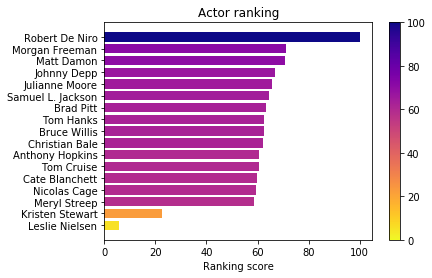

In [3]:
import matplotlib.pyplot as plt 
import matplotlib.colors

def plot_rankings(best_actors, mid, bottom):
    total_length = len(best_actors) + len(mid) + len(bottom)
    names = []
    scores = []
    rank_const = 100.0 / best_actors[0][1] #Making the #1 actor get a 100 score
    
    for a in best_actors:
        names.append(a[0])
        scores.append(a[1]*rank_const) # Append with adjusted score

    names.append(mid[0])
    scores.append(mid[1]*rank_const)
    names.append(bottom[0])
    scores.append(bottom[1]*rank_const)
    
    fig, ax = plt.subplots()
    cmap = plt.cm.plasma_r #Color map of scores
    norm = matplotlib.colors.Normalize(vmin=0, vmax=scores[0]) # Normalize so that color goes from 0 to max score (100)
    
    y_pos = np.arange(total_length - 2)
    ax.barh(y_pos, scores, align='center', color=cmap(norm(scores)))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.set_xlabel('Ranking score')
    ax.set_title('Actor ranking')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm) # Create color bar to right for reference
    plt.show()

best_actors = [] #Create tuples with names and ids of top15 actors
for a in top15:
    name = data[data['nconst'] == a].iloc[0]['actorName']
    best_actors.append((name, p.get(a)))

bottom = (data[data['nconst'] == bottom1].iloc[0]['actorName'], p.get(bottom1))
mid = (data[data['nconst'] == mid1].iloc[0]['actorName'], p.get(mid1))

plot_rankings(best_actors, mid, bottom)

I also plotted a subnetwork of only the top15 actors and their edges to each other, with ranking score represented in node size. I only used this to get a better overview of the data, and it wasn’t used for any further analysis. I used this to get an idea for how many movies the top15 actors have participated in together, and with this I decided that I had to use top 50 actors for the further analysis. NetworkX does not take the node tags size into account when plotting (so they get cut off), but since this isn’t my main visualization for the ranking I did not invest time in finding a fix.

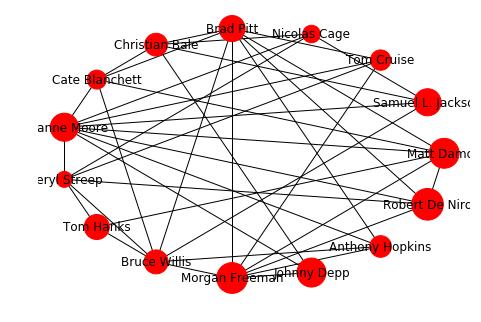

In [4]:
def graph_subnetwork(G, actors, data):
    best_actors = actors
    topG = nx.Graph()
    n_actors = len(best_actors)
    
    for i in range(n_actors-1): #Create edges between top 15 actors that have edges in G
        a1 = best_actors[i]
        for j in range(i+1, n_actors):
            a2 = best_actors[j]
            if G.has_edge(a1, a2):
                w = G[a1][a2]['weight']
                topG.add_edge(a1, a2, weight = w) 

    # Create list of nodesizes to visually represent ranking
    nodesizes = [1000-800*i/n_actors for i in range(n_actors)]
    nodelist = []
    
    relabel = {} # Relabel with name instead of nconst
    for a in best_actors:
        name = data[data['nconst'] == a].iloc[0]['actorName']
        relabel[a] = name
        nodelist.append(name)

    topG = nx.relabel_nodes(topG, relabel)
    nx.draw_circular(topG, nodelist = nodelist, node_size = nodesizes, with_labels=True)
    plt.show()

graph_subnetwork(G, top15, data) 

## Part 3. Explore the data and attempt to find a formula to create a successful movie

Apart from the data in previous parts, I also loaded the title.crew.tsv file to get the directors and writers for the titles. I later noticed they were also in the title.principals.tsv file, but had been filtered out when I just kept the actors. Either file would work though.

- Amount of movies in filtered data: 5151
- Average rating for filtered data: 6.7267
- Standard deviation of ratings: 0.78761

My first hypothesis for a formula to test had the following criteria:
- Choose the director with most edges to top 50 actors
- Choose the 3 top 50 actors that the director has most edges to 
- Choose the 2 writer(s) that the director has most edges to

I did this test when I filtered the data for 6.0+ ratings instead of 5.0+. My only match was Ocean’s Eleven with a 7.8 rating. While this is a very good rating, it’s hard to make any conclusion about the formula with such a small sample size.

My second hypothesis for a formula had the following criteria:
- Director(s) with experience from dir_mov_count+ movies, and at least one movie together with a top 50 actor
- Writer(s) with experience from wrt_mov_count+ movies, and at least one movie together with a top 50 actor
- At least top50_actor_count top 50 actors in movie

Where the count variables are adjusted to explore the different results. I coded this using the title.crew.tsv and title.principals.tsv files, together with the list of top 50 actors and the filtered data that had been augmented with movie ratings previously.


| Case | Variables | Movie count | Average rating |
|------|-----------|-------------|----------------|
|   A  | 10, 10, 2 |      26     | 7.054          |
|   B  | 5, 5, 3   |      13     | 7.192          |
|   C  | 5, 5, 2   |      96     | 7.141          |
|   D  | 10, 10, 1 |      45     | 7.124          |
|   E  | 10, 10, 2 |      88     | 6.976          |
|   F  | 4, 10, 3  |      4      | 7.225          |
|   G  | 5, 2, 4   |      3      | 7.8            |
|   H  | 20, 2, 2  |      18     | 7.417          |
|   I  | 20, 5, 1  |      41     | 7.224          |
|   J  | 5, 1, 3   |      20     | 7.215          |


Variables are in order: director movie count, writer movie count, top 50 actor count.

From the different cases we can observe that experienced directors and amount of top 50 actors are more important than experienced writers, as case G and case H score the highest average rating. Since it’s likely very expensive to have 4 top 50 actors in the same movie, I would advise to go with the experienced director route. Also, we have a larger sample size for case H. Still, the average rating for case H is just 0.88 standard deviations above the mean of the filtered data, so it’s hard to make the statement that this is a clear formula to guarantee a very successful movie. We can still state that it would be a decently good guideline/formula to increase the chances of a successful movie to hire a director with over 20 titles in experience and get at least two top 50 actors.

In [ ]:
def hypothesis(top50_actors, actor_data, crew_data, principals_data, dir_mov_count, wrt_mov_count, top50_actor_count):    
    dir_movs = {} # Dictionary with movie count for each director
    wrt_movs = {}
    for mov in set(crew_data['tconst']): # For every movie
        dir_crew = crew_data[crew_data['tconst'] == mov].iloc[0]['directors']
        wrt_crew = crew_data[crew_data['tconst'] == mov].iloc[0]['writers']
        dirs = dir_crew.split(',')
        wrts = wrt_crew.split(',')
        for d in dirs:
            if dir_movs.has_key(d) == False:
                dir_movs[d] = 1
            else:
                dir_movs[d] += 1
        for w in wrts:

            if wrt_movs.has_key(w):
                wrt_movs[w] += 1
            else:
                wrt_movs[w] = 1
    
    dir_over = {k:v for (k,v) in dir_movs.items() if v >= dir_mov_count} #Only keep those with more than dir_mov_count
    wrt_over = {k:v for (k,v) in wrt_movs.items() if v >= wrt_mov_count}
    dir_over = dir_over.keys() # From now we only care about keys (nconst of directors)
    wrt_over = wrt_over.keys()
    
    directors = principals_data[principals_data['category'] == 'director']
    writers = principals_data[principals_data['category'] == 'writer']
    
    matched_dirs = directors[directors['nconst'].isin(dir_over)] # Filter out directors with less than critera
    matched_wrts = writers[writers['nconst'].isin(wrt_over)] # Filter out writers with less than critera
    
    matched_movs = actor_data[actor_data['nconst'].isin(top50_actors)] # Movie should have at least one top50 actor
    matched_movs = matched_movs[matched_movs['tconst'].isin(matched_dirs['tconst'])] # Movie should have at least one director fulfilling criteria
    matched_movs = matched_movs[matched_movs['tconst'].isin(matched_wrts['tconst'])] # Movie should have at least one writer fulfilling criteria
    
    matched_movs = matched_movs.groupby('tconst')
    matched_movs = matched_movs.filter(lambda x: len(x) >= top50_actor_count) # Every row is an actor, and we filter out rows with less top 50 actors than criteria
    
    print "- Director(s) with experience from at least", dir_mov_count, "movies (and one or more edges to top 50 actors)"
    print "- Writer(s) with experience from at least", wrt_mov_count, "movies (and one or more edges to top 50 actors)"
    print "- At least", top50_actor_count, "top50 actors"
    
    ratings = list(matched_movs.drop_duplicates('tconst')['rating']) # Remove duplicate rows (several actors) to avoid multiple ratings per movie
    
    print "Matched movie count: ", len(ratings)
    avg_rating = np.mean(ratings)
    print "Average rating for matched movies: ", avg_rating
    return avg_rating



ratings = list(data.drop_duplicates('tconst')['rating'])
print "\nAmount of movies in filtered data:", len(ratings)
print "Average rating for filtered data:", np.mean(ratings)
print "Standard deviation of ratings:", np.std(ratings)


# Read crew/principals data for hypothesis
# Better to do it once and pass the data than doing it for each function call to reduce runtime
crew_data = pd.read_csv('title.crew.tsv', sep='\t', error_bad_lines=False)
crew_data = crew_data[crew_data['tconst'].isin(data['tconst'])]

principals_data =  pd.read_csv('title.principals.tsv', sep='\t', error_bad_lines=False)
principals_data = principals_data[principals_data['tconst'].isin(data['tconst'])]

actor_data = data

print "\nCase A:"
hypothesis(top50, actor_data, crew_data, principals_data, 10, 10, 2)
print "\nCase B:"
hypothesis(top50, actor_data, crew_data, principals_data, 5, 5, 3)
print "\nCase C:"
hypothesis(top50, actor_data, crew_data, principals_data, 5, 5, 2)
print "\nCase D:"
hypothesis(top50, actor_data, crew_data, principals_data, 5, 10, 2)
print "\nCase E:"
hypothesis(top50, actor_data, crew_data, principals_data, 10, 10, 1)
print "\nCase F:"
hypothesis(top50, actor_data, crew_data, principals_data, 4, 10, 3)
print "\nCase G:"
hypothesis(top50, actor_data, crew_data, principals_data, 5, 2, 4)
print "\nCase H:"
hypothesis(top50, actor_data, crew_data, principals_data, 20, 2, 2)
print "\nCase I:"
hypothesis(top50, actor_data, crew_data, principals_data, 20, 5, 1)
print "\nCase J:"
hypothesis(top50, actor_data, crew_data, principals_data, 5, 1, 3)


Amount of movies in filtered data: 5151
Average rating for filtered data: 6.7267715006794795
Standard deviation of ratings: 0.787612574969513

Case A:
- Director(s) with experience from at least 10 movies (and one or more edges to top 50 actors)
- Writer(s) with experience from at least 10 movies (and one or more edges to top 50 actors)
- At least 2 top50 actors
Matched movie count:  26
Average rating for matched movies:  7.053846153846153

Case B:
- Director(s) with experience from at least 5 movies (and one or more edges to top 50 actors)
- Writer(s) with experience from at least 5 movies (and one or more edges to top 50 actors)
- At least 3 top50 actors
Matched movie count:  13
Average rating for matched movies:  7.1923076923076925

Case C:
- Director(s) with experience from at least 5 movies (and one or more edges to top 50 actors)
- Writer(s) with experience from at least 5 movies (and one or more edges to top 50 actors)
- At least 2 top50 actors
Matched movie count:  96
Average 